#### **Setup**

In [1]:
## import essential modules 
import qumcmc 
from qumcmc.basic_utils import *
from qumcmc.energy_models import IsingEnergyFunction, Exact_Sampling

from qumcmc.classical_mcmc_routines import *
from qumcmc.quantum_mcmc_routines_qulacs import *     #for Qulacs Simulator backend
# from qumcmc.quantum_mcmc_routines_qulacs import quantum_enhanced_mcmc   #for qiskit Aer's Simulator backend 
from typing import Union
from qumcmc.trajectory_processing import *
from qumcmc.training import *

import seaborn as sns
import pickle

#############
import random
from qulacs import QuantumState
from qulacs_core import DensityMatrix

from qiskit.visualization import plot_histogram

def int_to_str(state_obtained, nspin):
    return f"{state_obtained:0{nspin}b}"

In [19]:
## set theme
sns.set_theme(context = 'paper')
# sns.set_style('ticks')

In [2]:
def random_ising_model(n_spins:int, seed:int, print_model:bool= False, ):

    np.random.seed(seed)
    
    ## construct problem Hamiltonian ##
    shape_of_J=(n_spins,n_spins)

    ## defining J matrix (mutual 1-1 interaction)
    # J =  np.round(np.random.choice([+1, 0, -1], size=(n_spins, n_spins)), decimals=2) 
    J =  np.random.uniform(low= -1, high= 1, size= shape_of_J )

    J = 0.5 * (J + J.transpose() )
    J = np.round( J - np.diag(np.diag(J)) , decimals= 3)

    # defining h
    h = np.round(0.4 * np.random.randn(n_spins), decimals=2)
    #h = np.round(np.random.uniform(low= -1, high = 1, size= (n_spins)), decimals=2)

    param_model = IsingEnergyFunction(J, h, name= 'param_model')
    
    if print_model : param_model.model_summary()

    return param_model


#### **Training Module**

#### Experiment 1 : Learning Haar-Random Samples

##### **5 qubits**

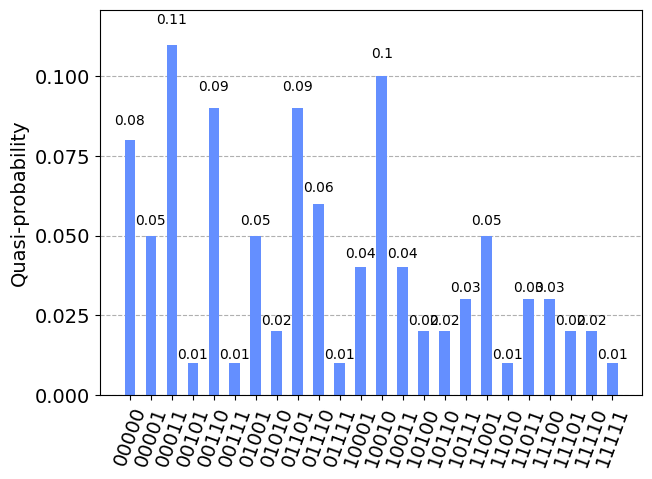

In [3]:
nspin = 5; seed = 1302365
st = QuantumState(nspin)
st.set_Haar_random_state(seed)
st_count = Counter([int_to_str(s, nspin) for s in st.sampling(100) ])

DATA = DiscreteProbabilityDistribution( dict(st_count))
# DATA._normalise()
plot_histogram(DATA)

In [20]:
param_model = random_ising_model(nspin, 1232, print_model= False)
beta_train = 0.75
param_model_exm = Exact_Sampling(param_model, beta= beta_train)
param_model_exm.sampling_summary()

In [6]:
train_cl = cd_training(param_model, beta_train, DATA)

train_cl.train(lr = 0.025 ,method = 'classical-uniform' , epochs= 200, 
iterations= nspin, num_random_Jij=nspin, mcmc_steps= 250 , show_kldiv= True)

training epochs: 100%|██████████| 200/200 [00:01<00:00, 195.50it/s, method =classical-uniform, kl div =0.408]


In [7]:
train_q = cd_training(param_model, beta_train, DATA)

train_q.train(lr = 0.025 ,method = 'quantum-enhanced' , epochs= 200, 
iterations= nspin, num_random_Jij=nspin, mcmc_steps= 250 , show_kldiv= True)

training epochs: 100%|██████████| 200/200 [00:15<00:00, 13.21it/s, method =quantum-enhanced, kl div =0.32] 


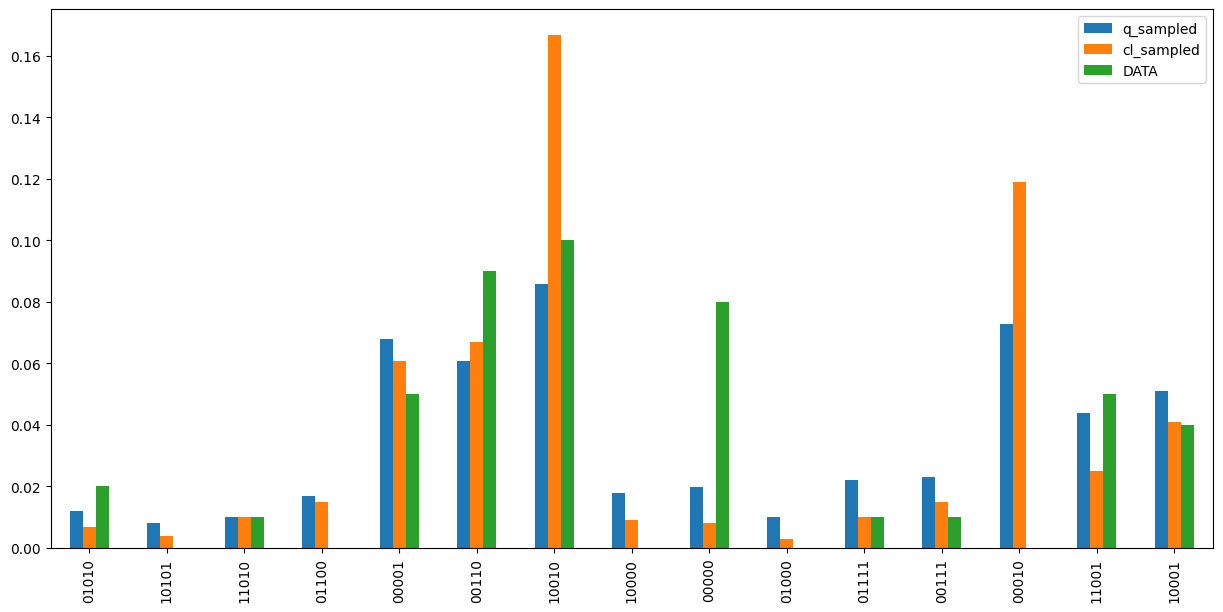

In [12]:
cl_sampled_dist = quantum_enhanced_mcmc(1000, train_cl.model,temperature= 1/beta_train, verbose=False  ).get_accepted_dict(normalize=True)
q_sampled_dist = quantum_enhanced_mcmc(1000, train_q.model,temperature= 1/beta_train, verbose=False  ).get_accepted_dict(normalize=True)
plot_multiple_bargraphs([q_sampled_dist,cl_sampled_dist, DATA], ['q_sampled','cl_sampled', 'DATA'], [False,False, True], plot_first_few= 15)

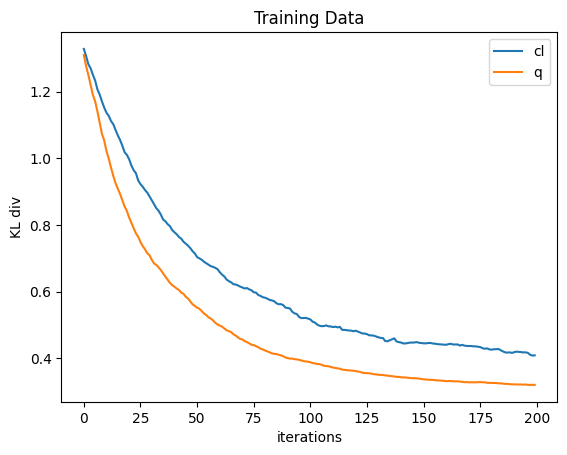

In [13]:
plt.plot(train_cl.training_history['kl_div'], label= 'cl')
plt.plot(train_q.training_history['kl_div'], label= 'q')
plt.xlabel('epochs'); plt.ylabel('KL div'); plt.title('Training Data')
plt.legend()
plt.yscale('log')
plt.show()

##### **10 qubits**

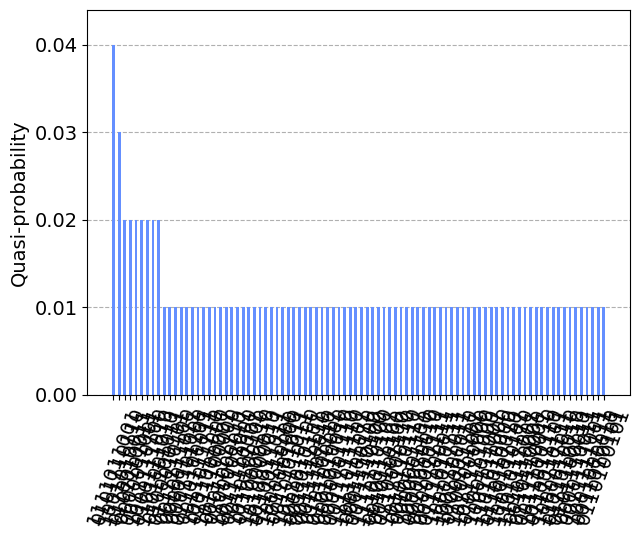

In [59]:
nspin = 10; seed = 9092365
st = QuantumState(nspin)
st.set_Haar_random_state(seed)
st_count = Counter([int_to_str(s, nspin) for s in st.sampling(100) ])

DATA = DiscreteProbabilityDistribution( dict(st_count))
# DATA._normalise()
plot_histogram(DATA,sort= 'value_desc', number_to_keep= 200, bar_labels=False)

     MODEL : param_model |  beta : 0.3
Num Most Probable States : 0
Entropy : None
---------------------------------------------


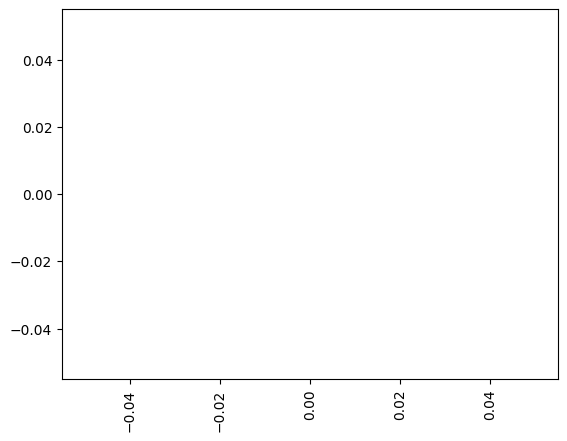

In [50]:
param_model = random_ising_model(nspin, 61232, print_model= False)
beta_train = 0.
param_model_exm = Exact_Sampling(param_model, beta= beta_train)
param_model_exm.sampling_summary()

In [52]:
train_cl = cd_training(param_model, beta_train, DATA)

train_cl.train(lr = 0.025 ,method = 'classical-uniform' , epochs= 200, 
iterations= nspin, num_random_Jij=nspin, mcmc_steps= 500 , show_kldiv= True)

training epochs: 100%|██████████| 200/200 [00:04<00:00, 42.31it/s, method =classical-uniform, kl div =2.38]


In [53]:
train_q = cd_training(param_model, beta_train, DATA)

train_q.train(lr = 0.025 ,method = 'quantum-enhanced' , epochs= 200, 
iterations= nspin, num_random_Jij=nspin, mcmc_steps= 2*250 , show_kldiv= True)

training epochs: 100%|██████████| 200/200 [03:26<00:00,  1.03s/it, method =quantum-enhanced, kl div =2.33]


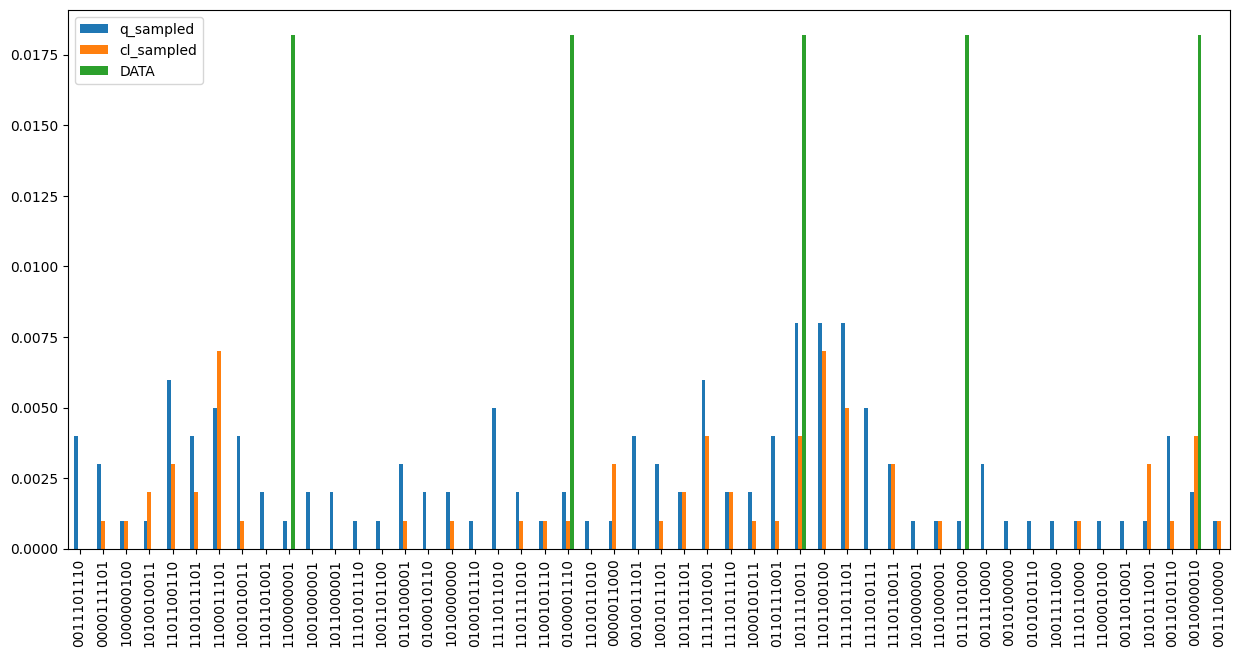

In [54]:
cl_sampled_dist = quantum_enhanced_mcmc(1000, train_cl.model,temperature= 1/beta_train, verbose=False  ).get_accepted_dict(normalize=True)
q_sampled_dist = quantum_enhanced_mcmc(1000, train_q.model,temperature= 1/beta_train, verbose=False  ).get_accepted_dict(normalize=True)
plot_multiple_bargraphs([q_sampled_dist,cl_sampled_dist, DATA], ['q_sampled','cl_sampled', 'DATA'], [False,False, True], plot_first_few= 50)

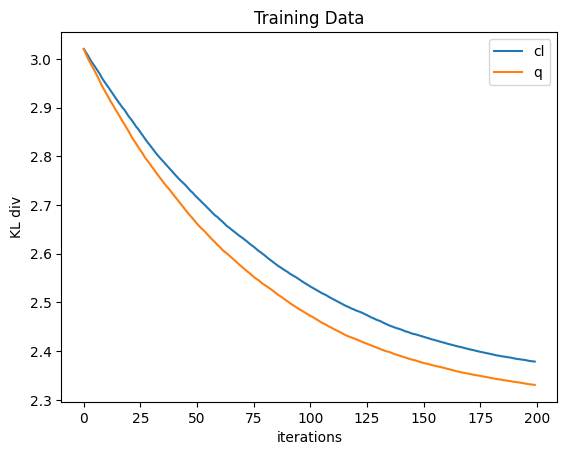

In [56]:
plt.plot(train_cl.training_history['kl_div'], label= 'cl')
plt.plot(train_q.training_history['kl_div'], label= 'q')
plt.xlabel('epochs'); plt.ylabel('KL div'); plt.title('Training Data')
plt.legend()
plt.yscale('log')
plt.show()

#### Experiment 2: Sampling from tensor product of single qubit rotations

##### **5 qubit**

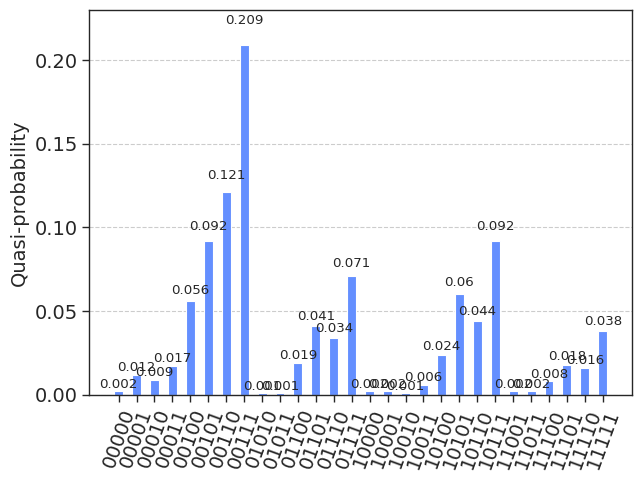

In [20]:
nspin = 5; seed = 131478
np.random.seed(seed)

st = QuantumState(nspin)
rqc = QuantumCircuit(nspin)
for i in range(nspin):
    rqc.add_RotY_gate(i, np.random.uniform(0,2 * np.pi))  ##random angles
    # rqc.add_RotY_gate(i, np.pi/2) ##fixed angles
rqc.update_quantum_state(st)

st_count = Counter([int_to_str(s, nspin) for s in st.sampling(1000) ])
beta_train = 1.0

DATA = DiscreteProbabilityDistribution( dict(st_count))
DATA._normalise()
plot_histogram(DATA)

In [21]:
param_model = random_ising_model(nspin, 5012, print_model= False)

In [22]:
train_cl = cd_training(param_model, beta_train, DATA)

train_cl.train(lr = 0.025 ,method = 'classical-uniform' , epochs= 200, 
iterations= nspin, num_random_Jij=nspin, mcmc_steps= 200 , show_kldiv= True)

training epochs: 100%|██████████| 200/200 [00:00<00:00, 248.53it/s, method =classical-uniform, kl div =0.35] 


In [26]:
train_q = cd_training(param_model, beta_train, DATA)

train_q.train(lr = 0.025 ,method = 'quantum-enhanced' , epochs= 200, 
iterations= nspin, num_random_Jij=nspin, mcmc_steps= 200 , show_kldiv= True)

training epochs: 100%|██████████| 200/200 [00:09<00:00, 20.60it/s, method =quantum-enhanced, kl div =0.0514]


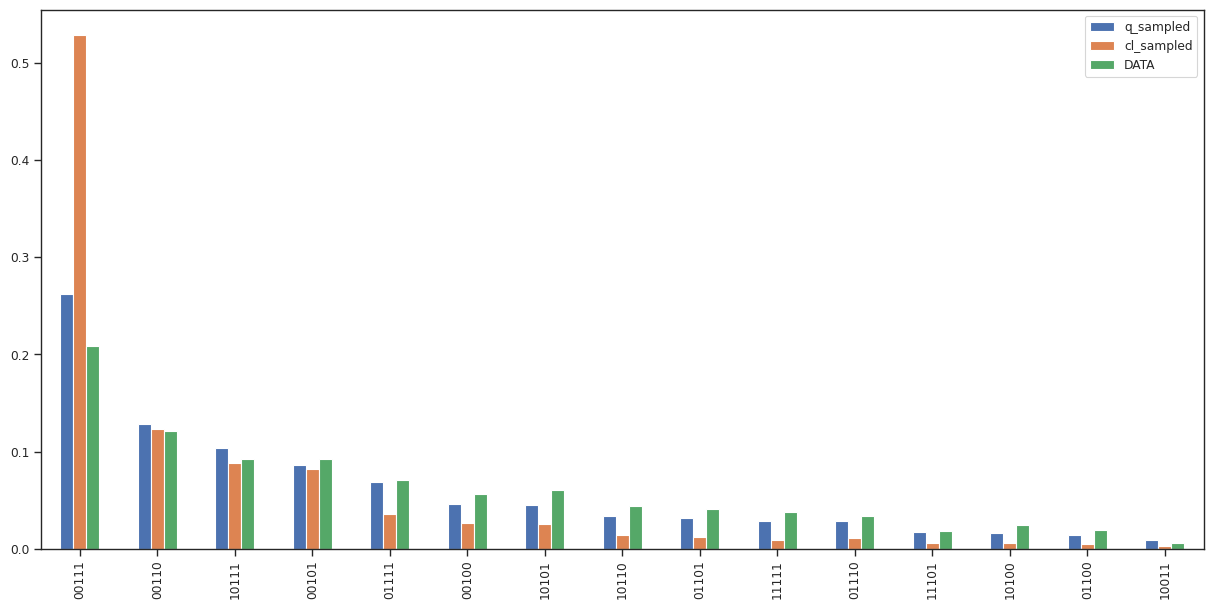

In [30]:
# cl_sampled_dist = quantum_enhanced_mcmc(1000, train_cl.model,temperature= 1/beta_train, verbose=False  ).get_accepted_dict(normalize=True)
# q_sampled_dist = quantum_enhanced_mcmc(1000, train_q.model,temperature= 1/beta_train, verbose=False  ).get_accepted_dict(normalize=True)
cl_sampled_dist = Exact_Sampling(train_cl.model, beta= beta_train).boltzmann_pd
q_sampled_dist = Exact_Sampling(train_q.model, beta= beta_train).boltzmann_pd
plot_multiple_bargraphs([q_sampled_dist,cl_sampled_dist, DATA], ['q_sampled','cl_sampled', 'DATA'], [False,False, True], plot_first_few= 15)

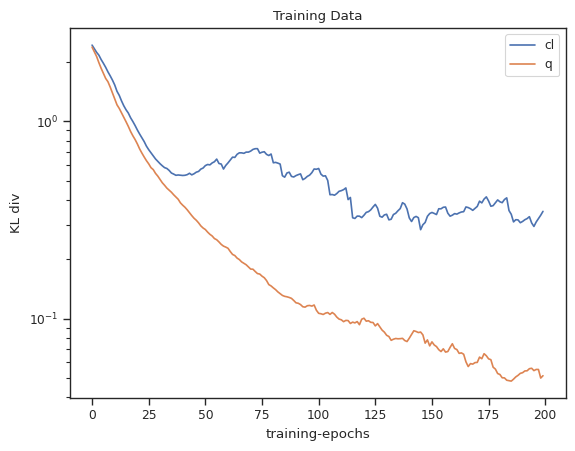

In [27]:
plt.plot(train_cl.training_history['kl_div'], label= 'cl')
plt.plot(train_q.training_history['kl_div'], label= 'q')
plt.xlabel('training-epochs'); plt.ylabel('KL div'); plt.title('Training Data')
plt.legend()
plt.yscale('log')
plt.show()

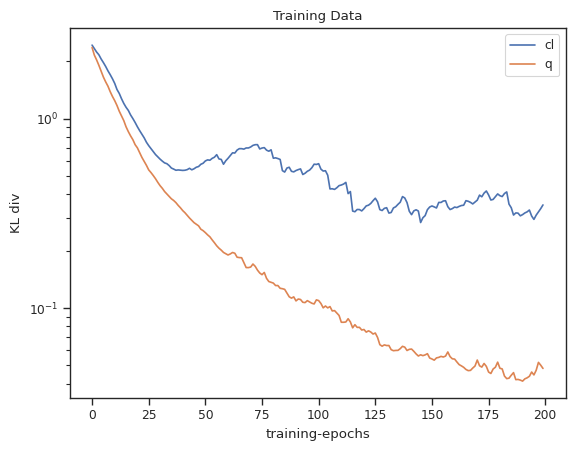

In [25]:
plt.plot(train_cl.training_history['kl_div'], label= 'cl')
plt.plot(train_q.training_history['kl_div'], label= 'q')
plt.xlabel('training-epochs'); plt.ylabel('KL div'); plt.title('Training Data')
plt.legend()
plt.yscale('log')
plt.show()

##### **10 qubit**

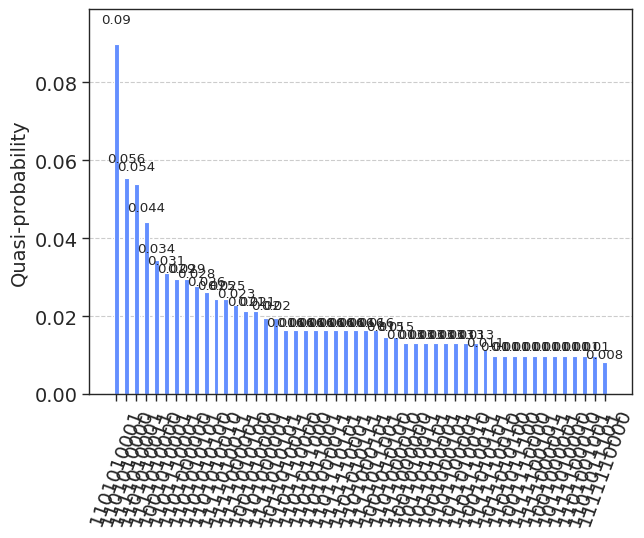

In [43]:
nspin = 10; seed = 5131478
np.random.seed(seed)

st = QuantumState(nspin)
rqc = QuantumCircuit(nspin)
for i in range(nspin):
    rqc.add_RotY_gate(i, np.random.uniform(0,2 * np.pi))  ##random angles
    # rqc.add_RotY_gate(i, np.pi/2) ##fixed angles
rqc.update_quantum_state(st)

st_count = Counter([int_to_str(s, nspin) for s in st.sampling(1000) ])

DATA = DiscreteProbabilityDistribution( dict(st_count))
DATA._normalise()
plot_histogram(DATA, sort='value_desc', number_to_keep= 50)

In [50]:
param_model = random_ising_model(nspin, 5012, print_model= False)
beta_train = 1.0; lr = 0.045

In [51]:
train_cl = cd_training(param_model, beta_train, DATA)

train_cl.train(lr = lr ,method = 'classical-uniform' , epochs= 200, 
iterations= nspin, num_random_Jij=nspin, mcmc_steps= 500 , show_kldiv= True)

training epochs: 100%|██████████| 200/200 [00:03<00:00, 56.70it/s, method =classical-uniform, kl div =1.21] 


In [52]:
train_q = cd_training(param_model, beta_train, DATA)

train_q.train(lr = lr ,method = 'quantum-enhanced' , epochs= 200, 
iterations= nspin, num_random_Jij=nspin, mcmc_steps= 500 , show_kldiv= True)

training epochs: 100%|██████████| 200/200 [03:11<00:00,  1.04it/s, method =quantum-enhanced, kl div =0.382]


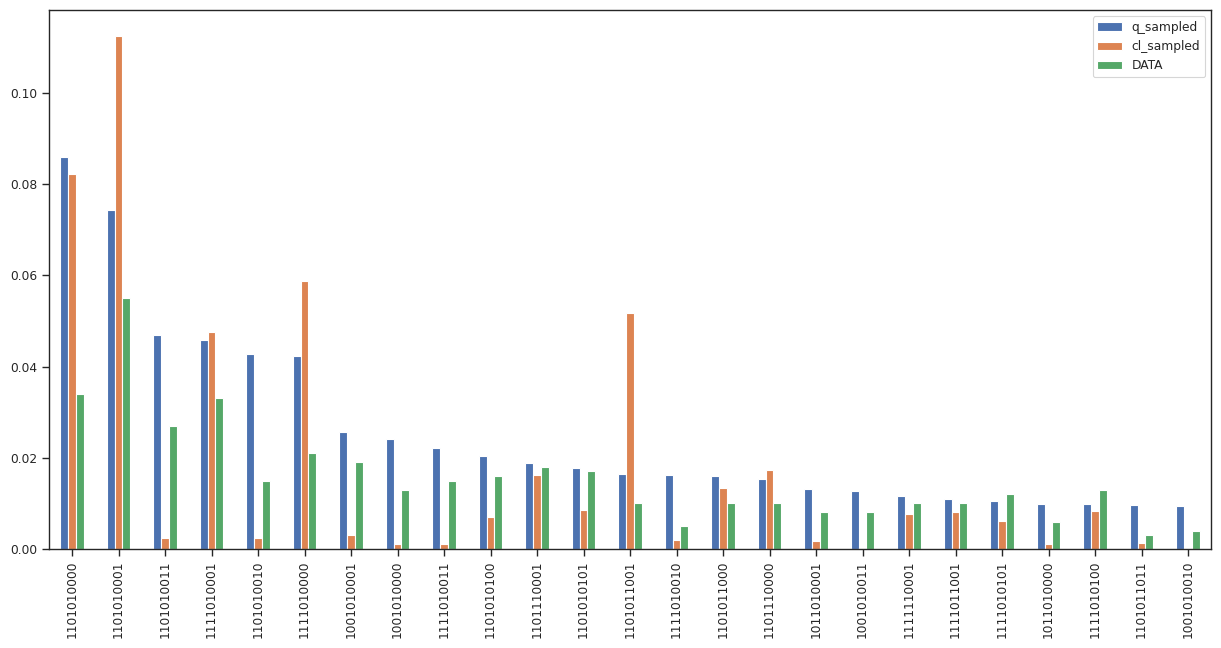

In [53]:
cl_sampled_dist = Exact_Sampling(train_cl.model, beta= beta_train).boltzmann_pd
q_sampled_dist = Exact_Sampling(train_q.model, beta= beta_train).boltzmann_pd
plot_multiple_bargraphs([q_sampled_dist,cl_sampled_dist, DATA], ['q_sampled','cl_sampled', 'DATA'], [False,False, True], plot_first_few= 25)

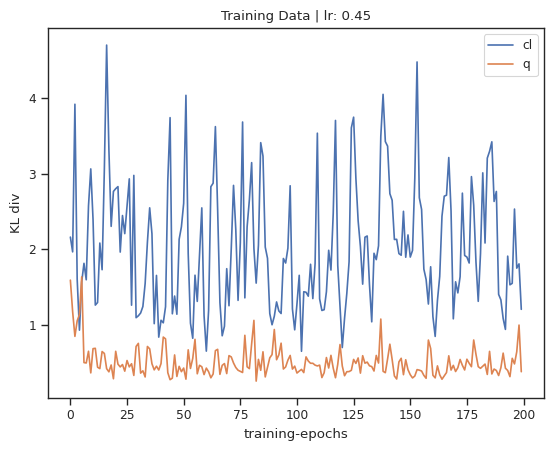

In [54]:
plt.plot(train_cl.training_history['kl_div'], label= 'cl')
plt.plot(train_q.training_history['kl_div'], label= 'q')
plt.xlabel('training-epochs'); plt.ylabel('KL div'); plt.title('Training Data | lr: '+str(lr))
plt.legend()
# plt.yscale('log')
plt.show()

##### **15 qubit**

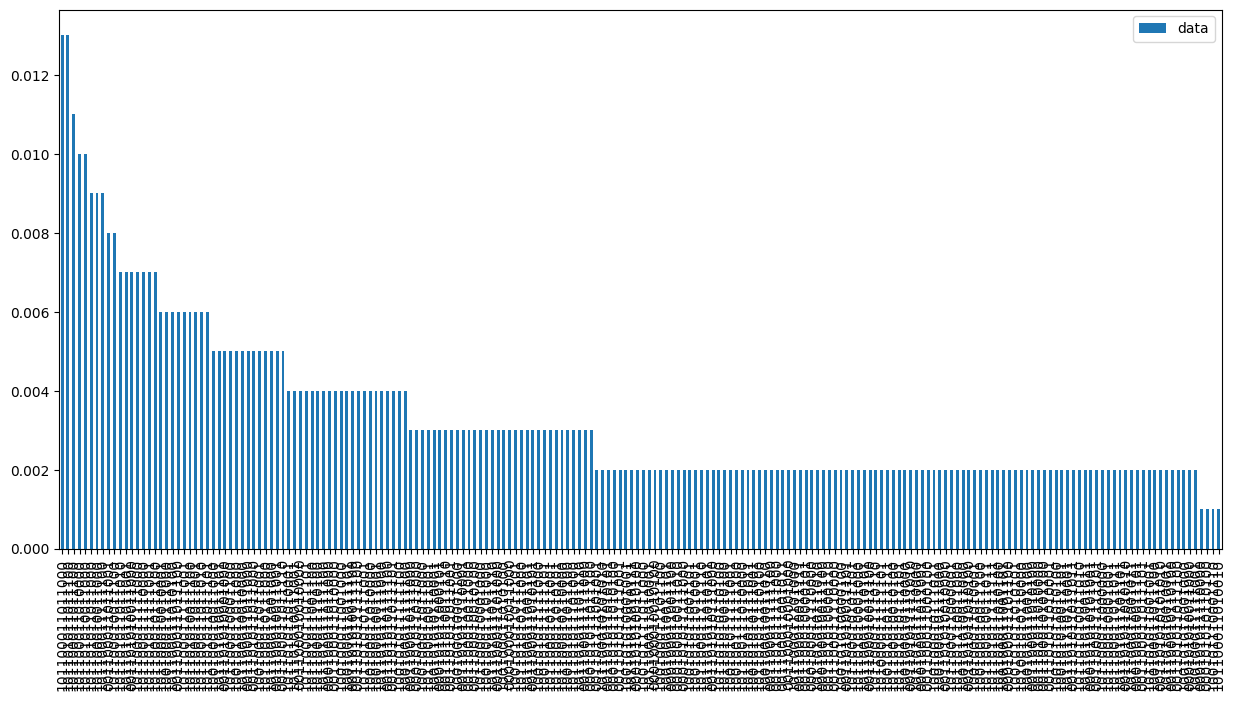

In [3]:
nspin = 15; seed = 25131478
np.random.seed(seed)

st = QuantumState(nspin)
rqc = QuantumCircuit(nspin)
for i in range(nspin):
    rqc.add_RotY_gate(i, np.random.uniform(0,2 * np.pi))  ##random angles
    # rqc.add_RotY_gate(i, np.pi/2) ##fixed angles
rqc.update_quantum_state(st)

st_count = Counter([int_to_str(s, nspin) for s in st.sampling(1000) ])

DATA = DiscreteProbabilityDistribution( dict(st_count))
# DATA._normalise()
# plot_histogram(DATA, sort='value_desc', number_to_keep= 50)
plot_multiple_bargraphs([DATA], ['data'], [False], 200, sort_desc=True)

In [4]:
param_model = random_ising_model(nspin, 5012, print_model= False); beta_train = 0.750

In [5]:
train_cl = cd_training(param_model, beta_train, DATA)

train_cl.train(lr = 0.025 ,method = 'classical-uniform' , epochs= 200, 
iterations= nspin, num_random_Jij=nspin, mcmc_steps= 500 , show_kldiv= True)

training epochs: 100%|██████████| 200/200 [01:25<00:00,  2.34it/s, method =classical-uniform, kl div =1.22]


In [7]:
train_q = cd_training(param_model, beta_train, DATA)

train_q.train(lr = 0.027 ,method = 'quantum-enhanced' , epochs= 100, 
iterations= nspin, num_random_Jij=nspin, mcmc_steps= 400 , show_kldiv= True)

with open('SamplingData/pickles/train_q15.pickle', 'wb') as f:
    pickle.dump(train_q, f)

training epochs: 100%|██████████| 100/100 [2:07:18<00:00, 76.39s/it, method =quantum-enhanced, kl div =0.887] 


starting with:  011000100100101 with energy: 2.9441468629905816


runnning quantum MCMC steps . ..: 100%|██████████| 1000/1000 [06:30<00:00,  2.56it/s]


starting with:  110011111101011 with energy: -5.083909837254212


runnning quantum MCMC steps . ..: 100%|██████████| 1000/1000 [08:01<00:00,  2.08it/s] 


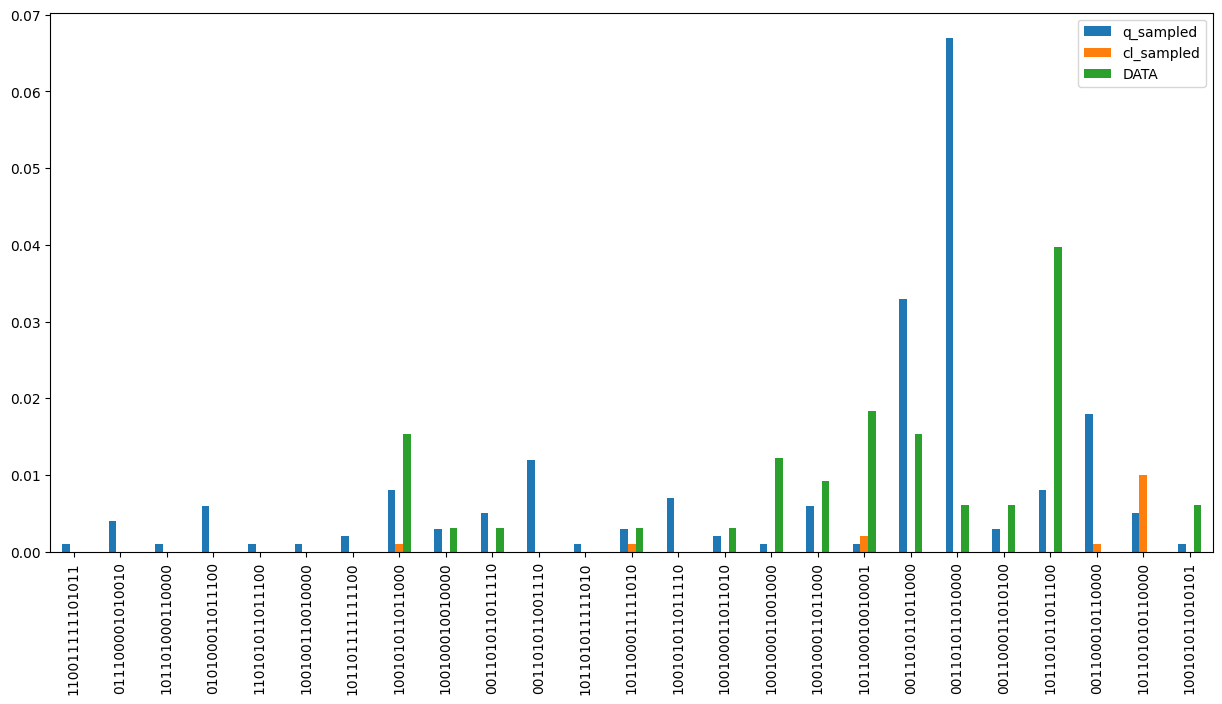

In [13]:
cl_sampled_dist = quantum_enhanced_mcmc(1000, train_cl.model,temperature= 1/beta_train, verbose=True  ).get_accepted_dict(normalize=True)
q_sampled_dist = quantum_enhanced_mcmc(1000, train_q.model,temperature= 1/beta_train, verbose=True  ).get_accepted_dict(normalize=True)
plot_multiple_bargraphs([q_sampled_dist,cl_sampled_dist, DATA], ['q_sampled','cl_sampled', 'DATA'], [False,False, True], plot_first_few= 25)

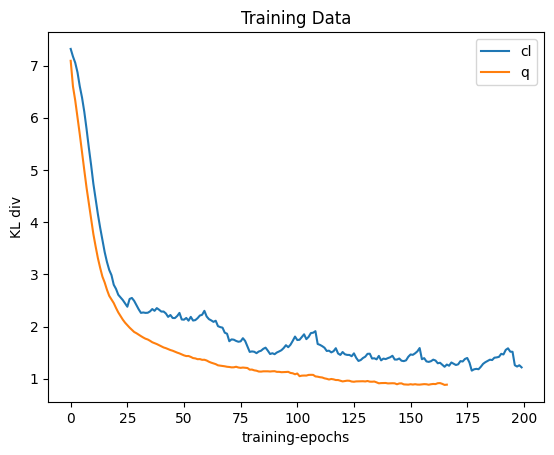

In [12]:
plt.plot(train_cl.training_history['kl_div'], label= 'cl')
plt.plot(train_q.kl_div, label= 'q')
plt.xlabel('training-epochs'); plt.ylabel('KL div'); plt.title('Training Data')
plt.legend()
# plt.yscale('log')
plt.show()

#### Experiment 3: Learning highly entangled states (GHZ/W)

In [3]:
nspin = 5; seed = 13571214
### GHZ data
def get_ghz_data(nspin:int):
    return DiscreteProbabilityDistribution({'1'*nspin: 0.5, '0'*nspin: 0.5  })

### W-state data
from itertools import permutations; import functools; import operator
def get_wstate_data(nspin:int):
    elems = list(Counter(permutations('1'+'0'*(nspin-1), nspin)))
    data = dict([( functools.reduce(operator.add, elem), 1.0 / nspin   ) for elem in elems])

    return DiscreteProbabilityDistribution(data)

##### GHZ

In [4]:
DATAghz = get_ghz_data(nspin)

     MODEL : param_model |  beta : 1.9
Num Most Probable States : 9
Entropy : 2.477885084700592
---------------------------------------------


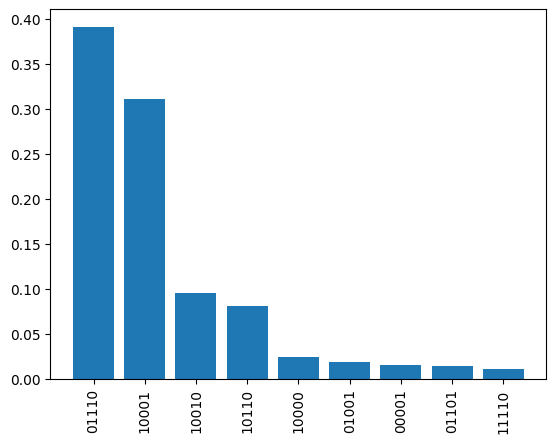

In [5]:
param_model = random_ising_model(nspin, 602872, print_model= False)
beta_train = 1.9
param_model_exm = Exact_Sampling(param_model, beta= beta_train)
param_model_exm.sampling_summary()

In [6]:
train_cl = cd_training(param_model, beta_train, DATAghz)

train_cl.train(lr = 0.025 ,method = 'classical-uniform' , epochs= 200, 
iterations= nspin, num_random_Jij=nspin, mcmc_steps= 50 , show_kldiv= True)

training epochs: 100%|██████████| 200/200 [00:01<00:00, 156.58it/s, method =classical-uniform, kl div =0.0148]


In [7]:
train_q = cd_training(param_model, beta_train, DATAghz)

train_q.train(lr = 0.025 ,method = 'quantum-enhanced' , epochs= 200, 
iterations= nspin, num_random_Jij=nspin, mcmc_steps= 50 , show_kldiv= True)

training epochs: 100%|██████████| 200/200 [00:08<00:00, 24.98it/s, method =quantum-enhanced, kl div =0.0651]


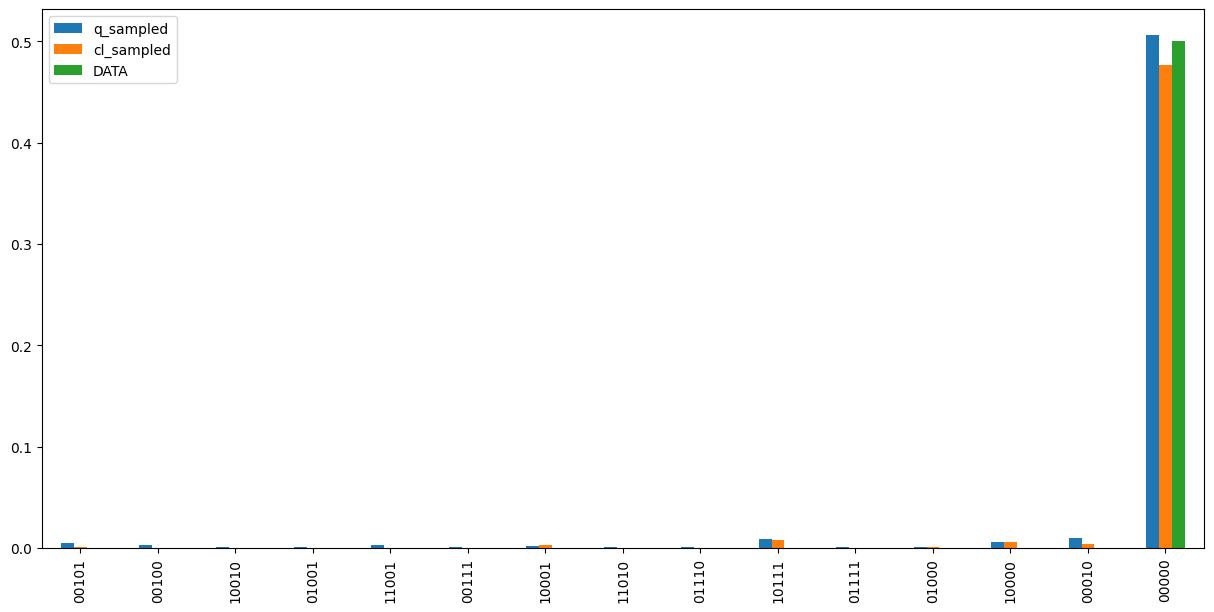

In [9]:
cl_sampled_dist = quantum_enhanced_mcmc(1000, train_cl.model,temperature= 1/beta_train, verbose=False  ).get_accepted_dict(normalize=True)
q_sampled_dist = quantum_enhanced_mcmc(1000, train_q.model,temperature= 1/beta_train, verbose=False  ).get_accepted_dict(normalize=True)
plot_multiple_bargraphs([q_sampled_dist,cl_sampled_dist, DATAghz], ['q_sampled','cl_sampled', 'DATA'], [False,False, True], plot_first_few= 15)

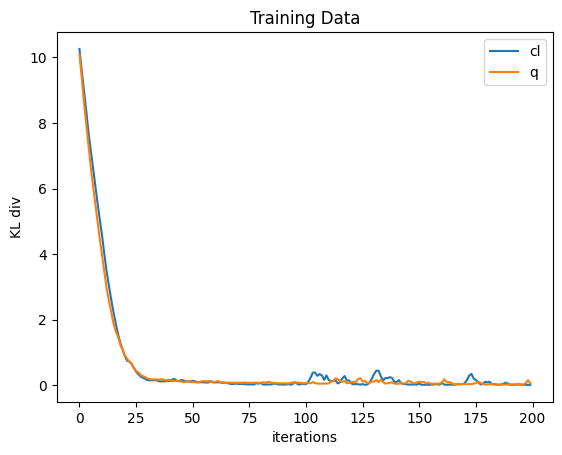

In [10]:
# plot_histogram([dict(cl_sampled_dist),dict(q_sampled_dist) ,DATA], legend= ['c','q','data'], figsize=(15,9))
plt.plot(train_cl.training_history['kl_div'], label= 'cl')
plt.plot(train_q.training_history['kl_div'], label= 'q')
plt.xlabel('iterations'); plt.ylabel('KL div'); plt.title('Training Data')
plt.legend()
plt.show()

In [32]:
# trained_model = train_q.model
# exsm_trained_model = Exact_Sampling(trained_model, beta_train, verbose= False)
# exsm_trained_model.sampling_summary()

##### W State

In [11]:
DATAw = get_wstate_data(nspin)

In [12]:
train_cl = cd_training(param_model, beta_train, DATAw)

train_cl.train(lr = 0.03 ,method = 'classical-uniform' , epochs= 250, 
iterations= nspin, num_random_Jij=nspin, mcmc_steps= 50 , show_kldiv= True)

training epochs: 100%|██████████| 250/250 [00:01<00:00, 158.04it/s, method =classical-uniform, kl div =0.541]


In [16]:
train_q = cd_training(param_model, beta_train, DATAw)

train_q.train(lr = 0.03 ,method = 'quantum-enhanced' , epochs= 250, 
iterations= nspin, num_random_Jij=nspin, mcmc_steps= 50 , show_kldiv= True)

training epochs: 100%|██████████| 250/250 [00:08<00:00, 29.14it/s, method =quantum-enhanced, kl div =0.492]


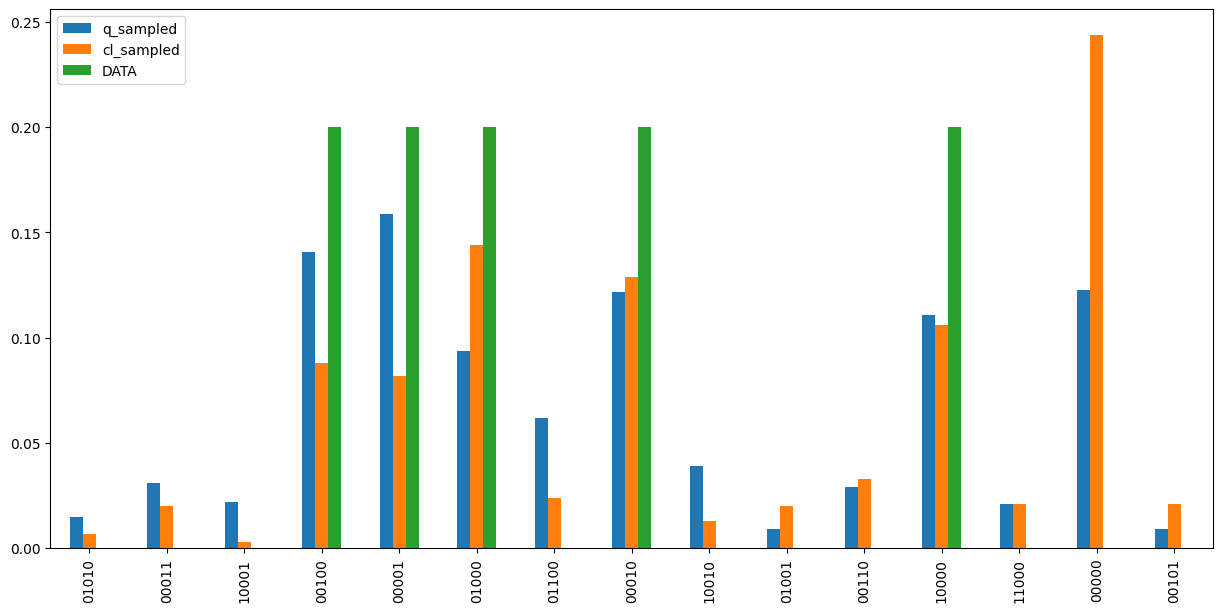

In [17]:
cl_sampled_dist = quantum_enhanced_mcmc(1000, train_cl.model,temperature= 1/beta_train, verbose=False  ).get_accepted_dict(normalize=True)
q_sampled_dist = quantum_enhanced_mcmc(1000, train_q.model,temperature= 1/beta_train, verbose=False  ).get_accepted_dict(normalize=True)
plot_multiple_bargraphs([q_sampled_dist,cl_sampled_dist, DATAw], ['q_sampled','cl_sampled', 'DATA'], [False,False, True], plot_first_few= 15)

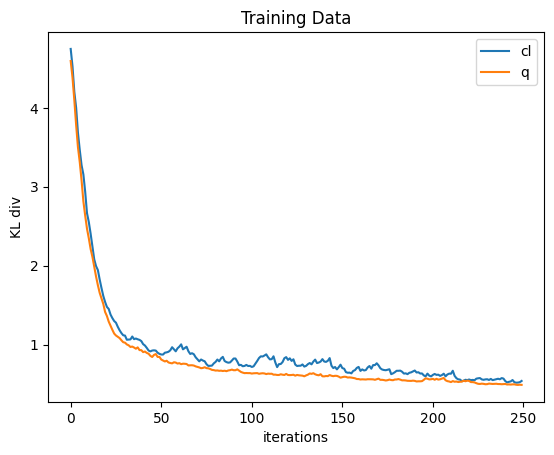

In [18]:
plt.plot(train_cl.training_history['kl_div'], label= 'cl')
plt.plot(train_q.training_history['kl_div'], label= 'q')
plt.xlabel('iterations'); plt.ylabel('KL div'); plt.title('Training Data')
plt.legend()
plt.show()

            MODEL : param_model
Non-zero Interactions (J) : 10 / 10
Non-zero Bias (h) : 5 / 5
---------------------------------------------
Average Interaction Strength <|J|> :  0.4372087114323011
Average Bias Strength <|h|>:  0.4190765686056997
alpha :  1.3674379552513023
---------------------------------------------


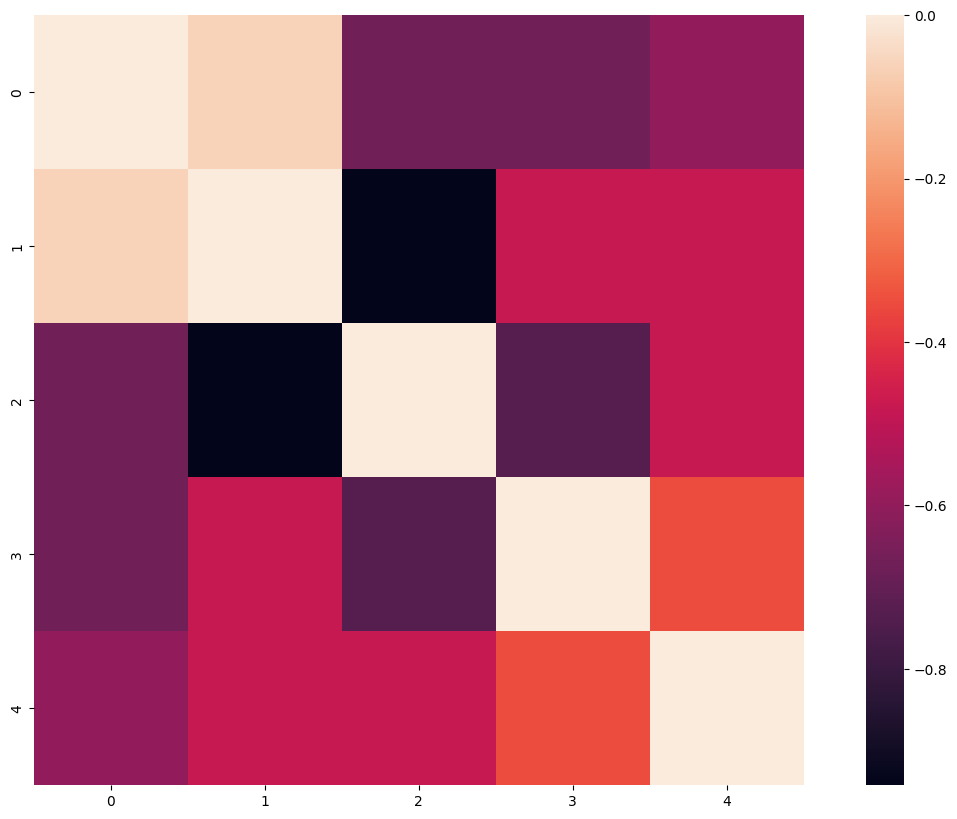

In [38]:
train_q.model.model_summary()

            MODEL : param_model
Non-zero Interactions (J) : 10 / 10
Non-zero Bias (h) : 5 / 5
---------------------------------------------
Average Interaction Strength <|J|> :  0.14990810885708708
Average Bias Strength <|h|>:  0.9429421796985261
alpha :  1.3674379552513023
---------------------------------------------


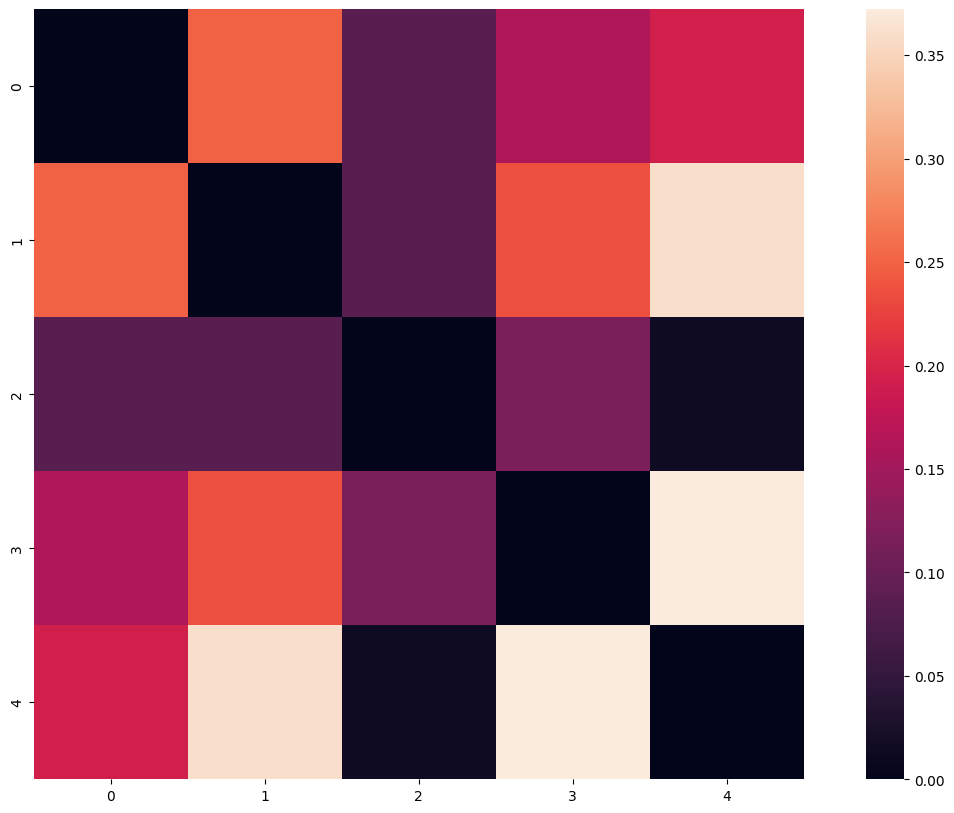

In [39]:
train_cl.model.model_summary()

#### Experiment 4: Bars and Stripes DataSet

In [3]:
data = pd.read_json('SamplingData/3x3_training_set.json')
trd = []
for _ in range(data.shape[0]):
    d = np.array(data['values'][_][:-1])
    d = np.where(d < 0.5, 0, 1)
    st = ''
    for i in range(len(d)): st += str(d[i])
    trd.append(st)
DATA_bs = DiscreteProbabilityDistribution(Counter(trd))

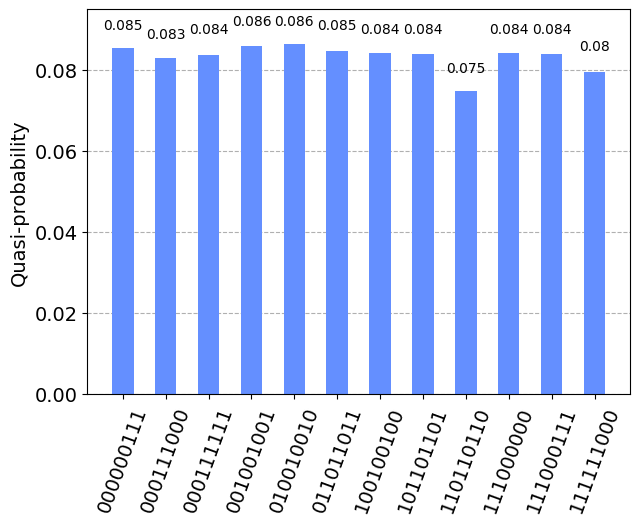

In [4]:
plot_histogram(DATA_bs)

In [10]:
nspin = len(list(DATA_bs.keys())[0])

     MODEL : param_model |  beta : 1.0
Num Most Probable States : 25
Entropy : 6.504812358855565
---------------------------------------------


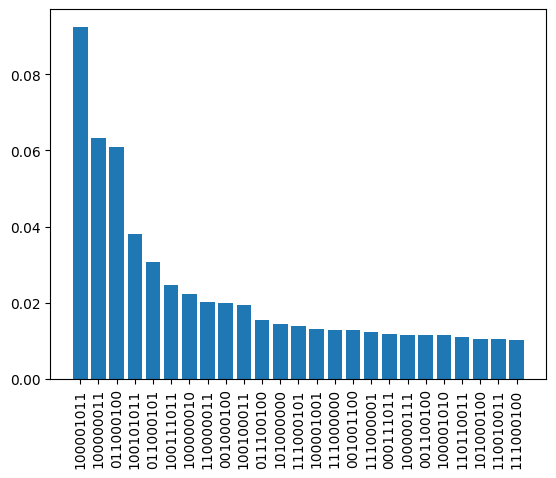

In [11]:
param_model = random_ising_model(nspin, 61232, print_model= False)
beta_train = 1.0
param_model_exm = Exact_Sampling(param_model, beta= beta_train)
param_model_exm.sampling_summary()

In [16]:
# train_cl = cd_training(param_model, beta_train, DATA_bs)

train_cl.train(lr = 0.025 ,method = 'classical-uniform' , epochs= 100, 
iterations= nspin, num_random_Jij=nspin, mcmc_steps= 500 , show_kldiv= True)

training epochs: 100%|██████████| 100/100 [00:02<00:00, 36.07it/s, method =classical-uniform, kl div =0.13]


In [17]:
# train_q = cd_training(param_model, beta_train, DATA_bs)

train_q.train(lr = 0.025 ,method = 'quantum-enhanced' , epochs= 50, 
iterations= nspin, num_random_Jij=nspin, mcmc_steps= 2*250 , show_kldiv= True)

training epochs: 100%|██████████| 50/50 [01:06<00:00,  1.32s/it, method =quantum-enhanced, kl div =0.324]


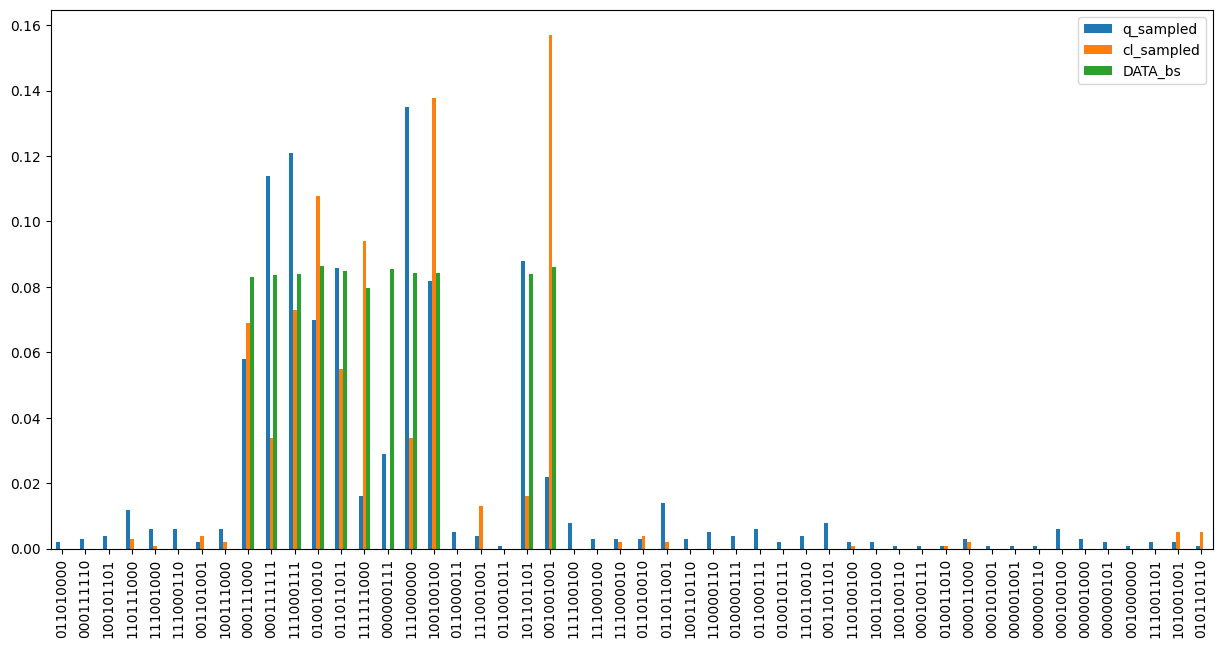

In [18]:
cl_sampled_dist = quantum_enhanced_mcmc(1000, train_cl.model,temperature= 1/beta_train, verbose=False  ).get_accepted_dict(normalize=True)
q_sampled_dist = quantum_enhanced_mcmc(1000, train_q.model,temperature= 1/beta_train, verbose=False  ).get_accepted_dict(normalize=True)
plot_multiple_bargraphs([q_sampled_dist,cl_sampled_dist, DATA_bs], ['q_sampled','cl_sampled', 'DATA_bs'], [False,False, True], plot_first_few= 50)

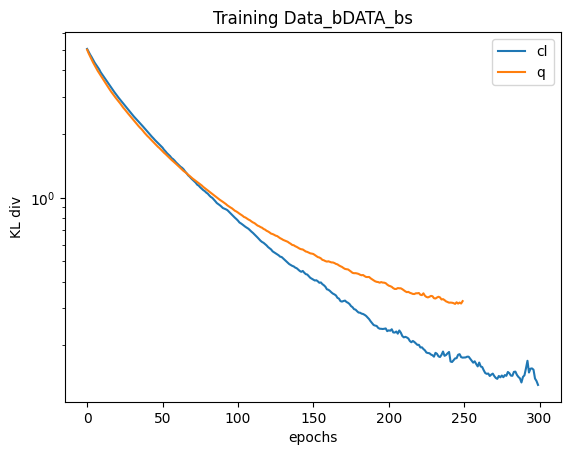

In [19]:
plt.plot(train_cl.training_history['kl_div'], label= 'cl')
plt.plot(train_q.training_history['kl_div'], label= 'q')
plt.xlabel('epochs'); plt.ylabel('KL div'); plt.title('Training Data_bDATA_bs')
plt.legend()
plt.yscale('log')
plt.show()